In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

# Display the image in jupyter notebook
%matplotlib inline

np.random.seed(1)

In [2]:
def load_dataset():
    # Train Dataset
    train_dataset = h5py.File('train_catvnoncat.h5', 'r')
    X_train = np.array(train_dataset['train_set_x'][:])
    Y_train = np.array(train_dataset['train_set_y'][:])
    classes = np.array(train_dataset['list_classes'][:])
    
    # Test Dataset
    test_dataset = h5py.File('test_catvnoncat.h5', 'r')
    X_test = np.array(test_dataset['test_set_x'][:])
    Y_test = np.array(test_dataset['test_set_y'][:])
    
    # Reshape Y_train and Y_test to 1 row
    Y_train = Y_train.reshape((1, Y_train.shape[0]))
    Y_test = Y_test.reshape((1, Y_test.shape[0]))
    
    return X_train, Y_train, X_test, Y_test, classes
   

In [3]:
def preprocessing(X_train, X_test):
    # Reshape image dataset to flatten
    X_train = X_train.reshape(X_train.shape[0], -1).T
    X_test = X_test.reshape(X_test.shape[0], -1).T
    
    # Standardise data by divided by 255
    X_train = X_train / 255
    X_test = X_test / 255
    
    return X_train, X_test

In [4]:
def initialize_parameters(dim):
    '''
    Initialize parameter W with random value. To minimize multiply it with 0.01
    Initialize parameter b with zeros
    '''
    np.random.seed(1)
    
    parameters = {}
    for i in range(1,len(dim)):
        parameters['W' + str(i)] = np.random.randn(dim[i], dim[i-1]) / np.sqrt(dim[i-1])
        parameters['b' + str(i)] = np.zeros((dim[i],1))

    return parameters

In [5]:
def sigmoid(Z):
    A = 1 / (1 + np.exp(-Z))
    cache = Z
    
    return A, cache

In [6]:
def relu(Z):
    # Cache Z for backpropagation
    A = np.maximum(0, Z)
    cache = Z
    
    return A, cache

In [7]:
def linear_forward(A, W, b):
    '''
    Compute the linear forward Z = W.A + b
    Cache A, W, b to use in backpropagation
    '''
   
    Z = np.dot(W, A) + b
    cache = (A, W, b)
    
    return Z, cache

In [8]:
def activation_forward(A, W, b, activation):
    if activation == 'relu':
        Z, linear_cache  = linear_forward(A, W, b)
        A, activation_cache = relu(Z)
    elif activation == 'sigmoid':
        Z, linear_cache  = linear_forward(A, W, b)
        A, activation_cache = sigmoid(Z)
        
    cache = (linear_cache, activation_cache)
    return A, cache

In [9]:
def forward_propagation(X, parameters):
    """
    A_prev contain the values of previous activation values.
    First layer activation value is X 
    From layer 1 to L-1 perform the activation 'ReLU'
    Layer L perform the activation 'Sigmoid'
    """
    A = X
    L = len(parameters) // 2 # Number of layers
    caches = []
    # Relu Forward activation   
    for i in range(1, L):
        A_prev = A
        A, cache = activation_forward(A_prev, parameters['W'+str(i)], parameters['b'+str(i)], activation = 'relu')
        caches.append(cache)
    # Sigmoid Forward activation
    AL, cache = activation_forward(A, parameters['W'+str(L)], parameters['b'+str(L)], activation = 'sigmoid')
    caches.append(cache)
    
    return AL, caches

In [10]:
def compute_cost(A, Y):
    # Number of samples
    m = Y.shape[1]
    c = (1./m) * (-np.dot(Y,np.log(A).T) - np.dot(1-Y, np.log(1-A).T)) 
    c = np.squeeze(c)
    
    return c

In [11]:
def sigmoid_backward(dA, cache):
    Z = cache
    sig = 1 / (1 + np.exp(-Z))
    dZ = dA * sig * (1-sig)
    
    return dZ

In [12]:
def relu_backward(dA, cache):
    Z = cache
    # Converting dZ to a correct object
    dZ = np.array(dA, copy = True)
    # When Z turn to 0, then dZ turns to 0
    dZ[Z <= 0] = 0
    
    return dZ

In [13]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    
    dW = (1./m) * np.dot(dZ, A_prev.T)
    db = (1./m) * np.sum(dZ, axis = 1, keepdims =True)
    dA_prev = np.dot(W.T, dZ)
    
    return dA_prev, dW, db

In [14]:
def activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    if activation == 'sigmoid':
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    elif activation == 'relu' :
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    return dA_prev, dW, db

In [15]:
def backward_propagation(AL, Y, caches):
    '''
    
    '''
    grads = {}
    L = len(caches) # Number of layers
    m = AL.shape[1]
    # Reshape Y to AL shape
    Y = Y.reshape(AL.shape)
    
    # Initialize the packpropagation
    dAL = -(np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    # Backpropagation on Lth layer (Sigmoid)
    current_cache = caches[L-1]
    grads['dA' + str(L-1)], grads['dW' + str(L)], grads['db' + str(L)] = activation_backward(dAL, current_cache, activation = 'sigmoid')
    
    # Backpropagation on L-1 to 1 th layer (relu)
    for i in reversed(range(L-1)):
        current_cache = caches[i]
        # dW + (i+1) data is used since reversed(range(4)) is 3,2,1,0 
        grads['dA' + str(i)], grads['dW' + str(i+1)], grads['db' + str(i+1)] = activation_backward(grads['dA' + str(i+1)], current_cache, activation = 'relu')
    
    return grads

In [16]:
def update_parameters(parameters, grads, learning_rate):
    
    L = len(parameters) // 2
    
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - (learning_rate * grads["dW" + str(l + 1)])
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - (learning_rate * grads["db" + str(l + 1)])
        
    return parameters
    

In [17]:
def model(X, Y, dim, learning_rate, iteration, print_cost = False):
    np.random.seed(3)
    costs =[]
    # Initialize parameters
    parameters = initialize_parameters(dim)
    
    ######### Loop Gradient Descent #########
    for i in range(0, iteration):
        ######### Forward Propagation ##########
        AL , cache = forward_propagation(X , parameters)
        
        ######### Compute cost ##########
        cost = compute_cost(AL, Y)
        
        ######### Backward propagation #########
        grads = backward_propagation(AL, Y, cache)
        
        ######### Update Parameters #########
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
        # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    return parameters  

Image showed below is a b'non-cat'


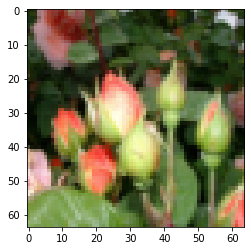

In [18]:
# Load Dataset
X_train, Y_train, X_test, Y_test, classes = load_dataset()
# Display the image
index = 36
print("Image showed below is a", classes[int(np.squeeze(Y_train[:,index]))] )
plt.imshow(X_train[index])

# Preprocess data
X_train, X_test = preprocessing(X_train, X_test)

Cost after iteration 0: 0.771749
Cost after iteration 100: 0.672053
Cost after iteration 200: 0.648263
Cost after iteration 300: 0.611507
Cost after iteration 400: 0.567047
Cost after iteration 500: 0.540138
Cost after iteration 600: 0.527930
Cost after iteration 700: 0.465477
Cost after iteration 800: 0.369126
Cost after iteration 900: 0.391747
Cost after iteration 1000: 0.315187
Cost after iteration 1100: 0.272700
Cost after iteration 1200: 0.237419
Cost after iteration 1300: 0.199601
Cost after iteration 1400: 0.189263
Cost after iteration 1500: 0.161189
Cost after iteration 1600: 0.148214
Cost after iteration 1700: 0.137775
Cost after iteration 1800: 0.129740
Cost after iteration 1900: 0.121225
Cost after iteration 2000: 0.113821
Cost after iteration 2100: 0.107839
Cost after iteration 2200: 0.102855
Cost after iteration 2300: 0.100897
Cost after iteration 2400: 0.092878


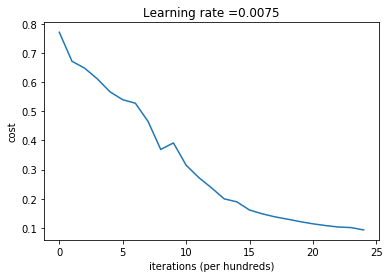

In [19]:
# Initialize the layer dimension
dim = [X_train.shape[0], 20, 7, 5, 1]

# Implement model
parameters = model(X_train, Y_train, dim, learning_rate = 0.0075, iteration = 2500, print_cost = True )

In [20]:
def predict(X, Y, parameters):
    
    m = X.shape[1]
    pred = np.zeros((1,m))
    
    # Perform forward propagation
    AL, cache = forward_propagation(X, parameters)
    
    # If predict greater than 0.5 then its a cat
    for i in range(0, AL.shape[1]):
        if AL[0,i] > 0.5 :
            pred[0, i] = 1
        else :
            pred[0, i] = 0
            
    return pred

In [21]:
predict_train = predict(X_train, Y_train, parameters)

print("Train Accuracy : " + str(np.sum((predict_train == Y_train) / X_train.shape[1])))

predict_test = predict(X_test, Y_test, parameters)

print("Test Accuracy : " + str(np.sum((predict_test == Y_test) / X_test.shape[1])))

Train Accuracy : 0.9856459330143539
Test Accuracy : 0.8
